In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision import models

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time


In [2]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc


def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred, _ = model(x)

        loss = criterion(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)



def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [3]:
BATCH_SIZE = 8
input_size = 224
lr =  0.00247655
first_conv_out = 64
first_fc_out = 64
img_trans = transforms.RandomRotation(degrees=(30, 70))

In [4]:


train_transforms = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    img_trans,
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

test_transforms = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

In [5]:
train_data = datasets.ImageFolder(root = "../42_split/train",
                                  transform = train_transforms)
valid_data = datasets.ImageFolder(root =  "../42_split/valid",
                                  transform = test_transforms)
test_data = datasets.ImageFolder(root =  "../42_split/test",
                                 transform = test_transforms)

In [6]:

train_iterator = data.DataLoader(train_data,
                                 shuffle = True,
                                 batch_size = BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data,
                                 batch_size = BATCH_SIZE)

test_iterator = data.DataLoader(test_data,
                                batch_size = BATCH_SIZE)

In [7]:
class CustomNet(nn.Module):
    def __init__(self, first_conv_out=first_conv_out, first_fc_out=first_fc_out):
        super().__init__()

        self.first_conv_out = first_conv_out
        self.first_fc_out = first_fc_out

        # All Conv layers.
        self.conv1 = nn.Conv2d(3, self.first_conv_out, 5)
        self.conv2 = nn.Conv2d(self.first_conv_out, self.first_conv_out*2, 3)
        self.conv3 = nn.Conv2d(self.first_conv_out*2, self.first_conv_out*4, 3)
        self.conv4 = nn.Conv2d(self.first_conv_out*4, self.first_conv_out*8, 3)
        self.conv5 = nn.Conv2d(self.first_conv_out*8, self.first_conv_out*16, 3)

        # All fully connected layers.
        self.fc1 = nn.Linear(self.first_conv_out*16, self.first_fc_out)
        self.fc2 = nn.Linear(self.first_fc_out, self.first_fc_out//2)
        self.fc3 = nn.Linear(self.first_fc_out//2, 120)

        # Max pooling layers
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        # Passing though convolutions.
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))

        # Flatten.
        bs, _, _, _ = x.shape
        x = F.adaptive_avg_pool2d(x, 1).reshape(bs, -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CustomNet()
model = model.to(device)

In [9]:
optimizer = optim.SGD(
    model.parameters(), lr=lr, momentum=0.9)



criterion = nn.CrossEntropyLoss()


criterion = criterion.to(device)

In [10]:
EPOCHS = 15

best_valid_loss = float('inf')

for epoch in trange(EPOCHS, desc="Epochs"):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'custom-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epochs:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/1853 [00:00<?, ?it/s]

ValueError: too many values to unpack (expected 2)

In [11]:
train_loss = []
test_loss = []
train_acc = []
test_acc = []

for epoch in range(1, 10):  # loop over the dataset multiple times

    running_loss = .0
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(train_iterator):
        # get the inputs
        # inputs, labels = data
        # if device == 'cuda':
        inputs, labels = images.to(device), labels.to(device)

        # reset the parameter gradients
        optimizer.zero_grad()

        # forward
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        # backward
        loss.backward()
        # optimize
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    running_loss /= len(train_iterator)
    train_loss.append(running_loss)
    running_acc = correct / total
    train_acc.append(running_acc)

    # if epoch % 4 == 0:
    print(f'\nEpoch: {epoch}')
    print(f'Train Acc. => {(100 * running_acc):.3f}%', end=' | ')
    print(f'Train Loss => {running_loss:.5f}')

    with torch.no_grad():
        correct = 0
        total = 0
        test_running_loss = .0
        for data in test_iterator:
            inputs, labels = data
            # if device == 'cuda':
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_running_loss /= len(test_iterator)
        test_loss.append(test_running_loss)
        test_running_acc = correct / total
        test_acc.append(test_running_acc)

        # if epoch % 4 == 0:
        print(f'Test Acc.  => {100 * test_running_acc:.3f}%', end=' | ')
        print(f'Test Loss  => {test_running_loss:.5f}')

print('Finished Training')


Epoch: 4
Train Acc. => 1.228% | Train Loss => 4.78092
Test Acc.  => 1.215% | Test Loss  => 4.77849

Epoch: 8
Train Acc. => 1.910% | Train Loss => 4.73057
Test Acc.  => 2.065% | Test Loss  => 4.70294
Finished Training


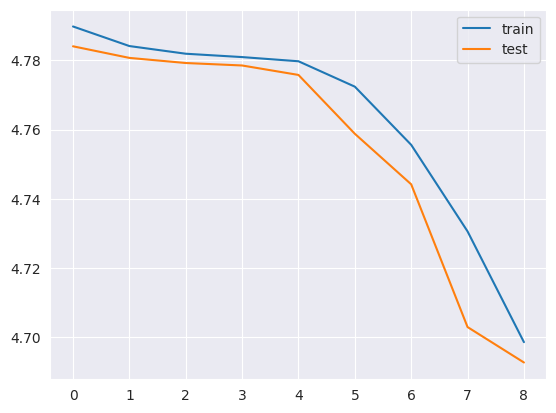

In [12]:
import matplotlib.pyplot as plt
plt.plot(train_loss, label='train')
plt.plot(test_loss, label='test')
plt.legend()
plt.show()

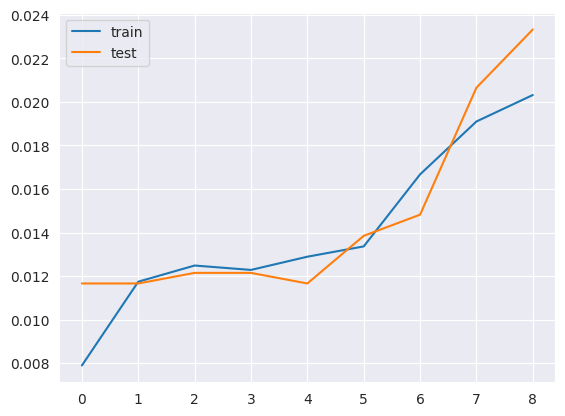

In [13]:
plt.plot(train_acc, label='train')
plt.plot(test_acc, label='test')
plt.legend()
plt.show()

In [ ]:
model.load_state_dict(torch.load('tut3-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')